# Speeding Up for Loops: Example Code

Run the cell below to import the necessary pacakges for this notebook. 

In [1]:
import warnings
from datetime import datetime

from lattice_hamiltonian.lattice import Lattice, Parameters

warnings.filterwarnings("ignore", category=RuntimeWarning)

In the cell below, we implement a calculation of the rate matrix using an element-by-element ```for``` loop. Each iteration of the ```for``` loop corresponds to a calculation of the rate of population transfer between a pair of eigenstates. In each iteration, we need to take the scalar product of two $(\mathrm{size})^{4} \times 1$ vectors and calculate the value of the correlation function at the energy corresponding to the difference in energy of the two eigenstates.  

In [2]:
import numpy as np
from naive_correlation_function import correlation_function_real_part_single

from lattice_hamiltonian.redfield import norm_spectral_density


def rates_mat_naive(lattice, params):
    """Calculate rates of population transfer between eigenstates.

    Rates are calculates using Redfield theory within the secular approximation as
    in Marcus and Renger 2002 & Quantum biology revisited 2020.

    Args:
    lattice: An instance of the lattice class for which the eigenstates have
    been found.
    params: An instance of the parameters class.
    """
    num_state = len(lattice.states)
    rates_mat = np.zeros((num_state, num_state))
    En_eV = lattice.states.energies
    occupation_probability = lattice.states.occupation_probability
    lambda_total = norm_spectral_density(
        params.lambda_outer + params.lambda_inner, params.e_peak
    )
    for index_i in range(len(lattice.states)):
        for index_j in range(index_i + 1, len(lattice.states)):
            w = En_eV[index_j] - En_eV[index_i]
            gamma = occupation_probability[index_j] @ occupation_probability[index_i]
            Cw_Re = correlation_function_real_part_single(
                w, lambda_total, params.e_peak, params.kT
            )
            rates_mat[index_j, index_i] = gamma * Cw_Re
            # Energetically uphill and downhill rates are related by a Boltzmann factor.
            rates_mat[index_i, index_j] = rates_mat[index_j, index_i] * np.exp(
                -w / params.kT
            )
    return rates_mat

Run the next cell to create a dictionary containing a series of lattices with different sizes (as described by the ```sizes``` list). This can take a little while as we need to find the eigenstates of each lattice. 

In [3]:
sizes = [4, 5, 6, 7, 8]
lattice_dict = {}
for i, s in enumerate(sizes):
    print(i)
    spacing = 10
    num_sites_coupled = 1.45
    size = s

    j0 = 1.5
    r0j = 0.1

    params = Parameters(
        temp=300,
        e_peak=0.16,
        lambda_inner=0.202,
        lambda_outer=0.048,
        j0=j0,
        r0j=r0j * spacing,
        e_singlet=1.4,
        const_recombination=True,
    )

    lattice = Lattice()
    lattice.generate_uniform(
        size=size,
        HOMO=0,
        LUMO=1.8,
        dist_sites=spacing,
        min_dist_near_neighbour=(num_sites_coupled * spacing) + 0.01,
        t0_homo=0.005,
        t0_lumo=0.005,
        d0=0.005,
        r0d=0.1 * spacing,
        v_ex=0,
        krec_ex=1e9,
        const_recombination=True,
    )

    lattice.build_ham(
        params,
        F=[0, 0, 0],
        min_dist_near_neighbour=(num_sites_coupled * spacing) + 0.01,
        disorder_site_ene=0.05,
        random_seed=42,
    )

    # calculate the eigenstates of the lattice
    lattice.states_from_ham(params, max_energy_diff=1.5)
    lattice_dict[i] = lattice

0
1
2
3
4


In the next cell, we use our element-by-element implementation of the code (defined above) to calculate the rate matrix for each lattice in ```lattice_dict```. 

In [4]:
# calculate the rates of transitions between states using the naive implementation
naive_times = np.zeros(len(sizes))
for i in range(len(sizes)):
    print(i)
    t1 = datetime.now()
    rates = rates_mat_naive(lattice_dict[i], params)
    t2 = datetime.now()
    naive_times[i] = (t2 - t1).total_seconds()

0
1
2
3
4


And now we calculate the rates using the vectorized version of the code...

In [5]:
# calculate the rates of transitions between states using vectorized code
vectorized_times = np.zeros(len(sizes))
for i in range(len(sizes)):
    print(i)
    t3 = datetime.now()
    lattice_dict[i].get_rate_mat(params)
    t4 = datetime.now()
    vectorized_times[i] = (t4 - t3).total_seconds()

0
1
2
3
4


Finally, we plot the difference in the times taken for the two versions of the code to calculate the rate matrix. By using a log-log, we can see that vectorizing the code substantialy speeds up the calculation but, to a good approximation, it does not change how the total time taken scales with the lattice size. 

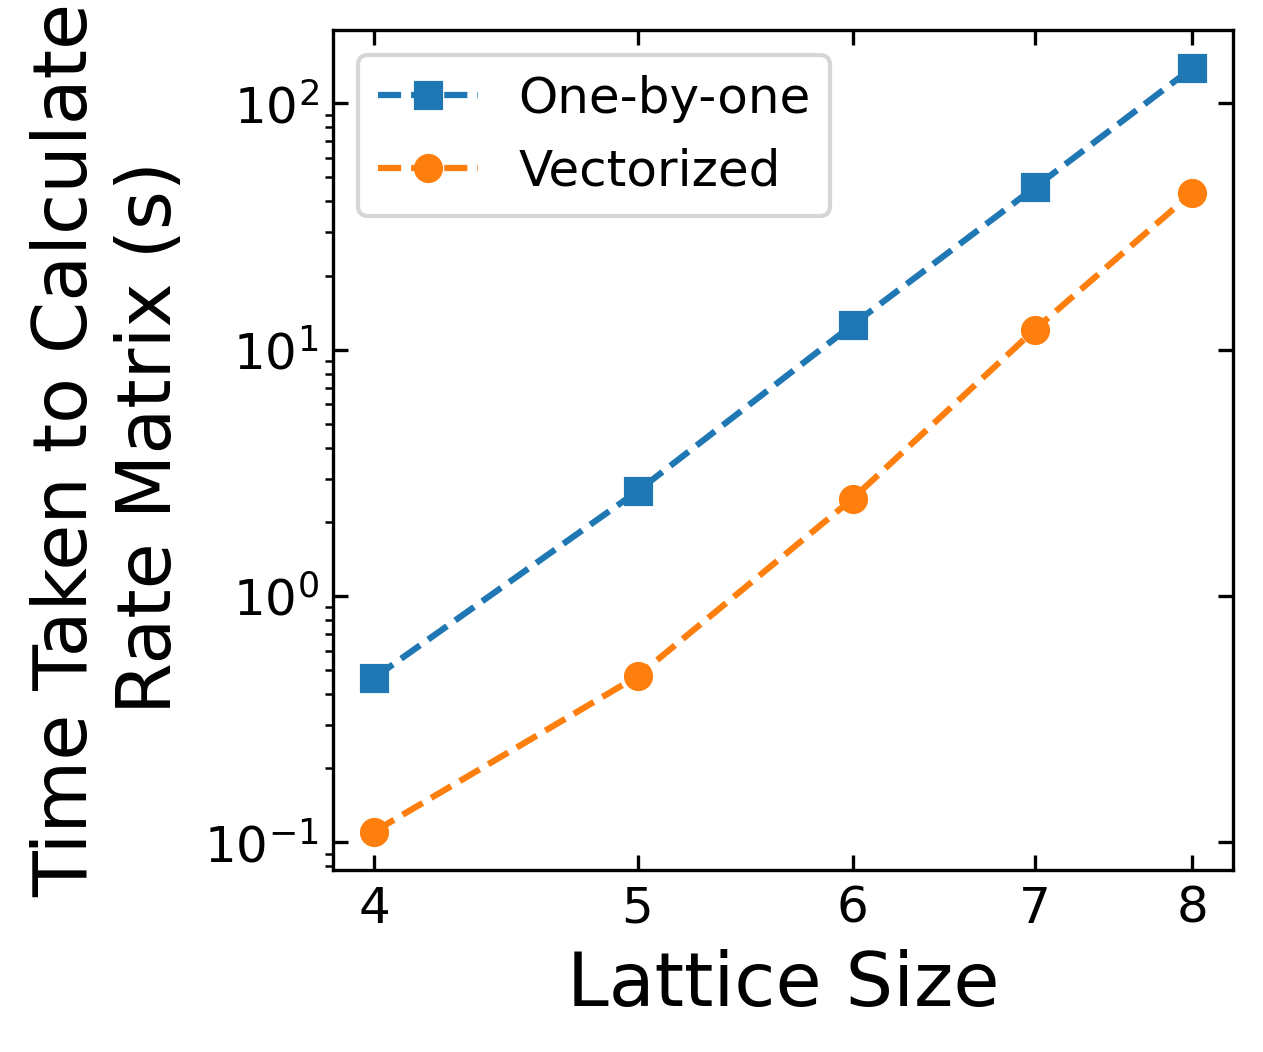

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4), facecolor="white", dpi=300)
ax = fig.add_axes([0.15, 0.25, 0.5, 0.7])
ax.loglog(sizes, naive_times, ls="--", marker="s", label="One-by-one")
ax.loglog(sizes, vectorized_times, ls="--", marker="o", label="Vectorized")

ax.set_xlabel("Lattice Size", fontsize=18)
ax.set_xticks(sizes,['4','5','6','7','8'])
ax.set_ylabel("Time Taken to Calculate\n Rate Matrix (s)", fontsize=18)
ax.tick_params(direction="in", right=True, top=True, labelsize=12)
ax.legend(fontsize=12)